In [1]:
!git config user.email "naazshafeer@gmail.com"
!git config user.name "Naaz Shafeer"

This is a separate notebook made to test the for loop made to see if my dynamical friction equation is coded correctly!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math

Intial Conditions

In [40]:
# region Code Snippet 1: This is the initial
G = const.G #change the innate time to years
m_gal = 1e11 * const.M_sun
#Masses
m1=1e7 * const.M_sun #mass of black hole A 
m2=1e8 * const.M_sun #mass of black hole B
# Will be adding the Standard Gravitational Parameter
mu = G.value * (m1.value+m2.value)
#r_i
r1=[1e3,0,0] * u.pc
r2=[-1e3,0,0] * u.pc
#To arrays
r1=np.array(r1,dtype="float64") * u.pc
r2=np.array(r2,dtype="float64") * u.pc

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)
#V_i
v1=[0,0.25e3, 0] *u.km/u.s
v2=[0,-0.25e3,0] *u.km/u.s #km/s

# v1 = v1.to(u.m / u.year)
# v2 = v2.to(u.m / u.year)

#To arrays
v1=np.array(v1,dtype="float64") *u.km/u.s
v2=np.array(v2,dtype="float64") *u.km/u.s
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

# r=np.linalg.norm(r2-r1) - note on this => we need to use based on COM frame so it would not be difference in distance between BH
#but the difference of each black hole from the COM as that can dictate the DF component on each BH
# region code : r that is used for Chandrasekhar's formula
r1_com = r1 - r_com
r2_com = r2 - r_com
 # region code : Semi Major Axes

rmax1 = np.max(r1 - r_com)
rmin1 = np.min(r1- r_com)
a1 = (rmax1+rmin1)/2

rmax2 = np.max(r2 - r_com)
rmin2 = np.min(r2 - r_com)
a2 = (rmax2+rmin2)/2
# endregion

o = (10**(2.2969)*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
# region code : Coulomb Logarithm
x1 = (np.abs(a1.to(u.km)) * o**(2)) / (G * m1)
x2 = (np.abs(a2.to(u.km)) * o**(2)) / (G * m2)
ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
# endregion

F_D1 = 0.428 * ln_A1 * ((G * m1**(2))/r1_com**(2))
F_D2 = 0.428 * ln_A2 * ((G * m1**(2))/r2_com**(2))


v_r = v2 - v1

v_rmag = np.sqrt(v_r[0]**2 + v_r[1]**2 + v_r[2]**2) #will be doing this from now on though linalg.norm does the same

v_rel_unit = (v_r / v_rmag)

# region code: Dynamical Friction Component to Array for BH A
F_D1_i = (F_D1 * v_rel_unit[0])
F_D1_j = (F_D1 * v_rel_unit[1])
F_D1_k = (F_D1 * v_rel_unit[2])
    
F_D1 = np.array([F_D1_i.to((u.kg*u.m)/(u.s**2)).value, F_D1_j.to((u.kg*u.m)/ (u.s**2)).value, F_D1_k.to((u.kg*u.m)/ (u.s**2)).value])
# endregion

# region code: Dynamical Friction Component to Array for BH B
F_D2_i = (F_D2 * v_rel_unit[0])
F_D2_j = (F_D2 * v_rel_unit[1])
F_D2_k = (F_D2 * v_rel_unit[2])
    
F_D2 = np.array([F_D2_i.to((u.kg*u.m)/(u.s**2)).value, F_D2_j.to((u.kg*u.m)/ (u.s**2)).value, F_D2_k.to((u.kg*u.m)/ (u.s**2)).value])
# endregion
    



F_D1 = F_D1 * ((u.kg * u.m)/(u.s**2))
F_D2 = F_D2 * ((u.kg * u.m)/(u.s**2))

    
T = 10 * u.Gyr # we can extract a from here - whole time in seconds
N = 5000
delta_t = T/ N

F_D1 = (F_D1 / m1).to(u.km / u.s**2)
F_D2 = (F_D2 / m2).to(u.km / u.s**2)

time_span=np.linspace(0, T, N) #Work on this with Kris' link

# endregion



~ So now we will implement those motion equations

Gravitational potential is distance between two bodies and is also affected by dynamical friction which that one depends on the distance from the COM (as the bigger black hole has smaller r and thus bigger DF and smaller BH has bigger r and smaller DF)


In [30]:
r1

<Quantity [1000.,    0.,    0.] pc>

In [42]:
rmax1 = np.max(r1 - r_com)
rmin1 = np.min(r1- r_com)
a1 = (rmax1+rmin1)/2

rmax2 = np.max(r2 - r_com)
rmin2 = np.min(r2 - r_com)
a2 = (rmax2+rmin2)/2

print(rmax2, rmin2)


0.0 pc -181.81818181818187 pc


In [46]:
r1_sol = []
r2_sol = []
v1_sol = []
v2_sol = []
F_D1_sol = []
F_D2_sol = []

for i in range(N):
    dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) - F_D1
    dv2bydt=((G*m1*(r2-r1))/r**3).to(u.km / u.s**2) - F_D2
    print("Shape of v1:", v1.shape)
    print("Shape of dv1bydt:", dv1bydt)
    v1 += dv1bydt * delta_t
    v2 += dv2bydt * delta_t

    r1 += v1.to(u.pc / u.s) * delta_t
    r2 += v2.to(u.pc / u.s) * delta_t
    #rcom - r1_sol that should be the one used for r**2 as we are looking at it as two bodies interacting with the COM
    

    r1_com = r1 - r_com
    r2_com = r2 - r_com

    # region code : Semi Major Axes

    rmax1 = np.max(r1 - r_com)
    rmin1 = np.min(r1- r_com)
    a1 = (rmax1+rmin1)/2

    rmax2 = np.max(r2 - r_com)
    rmin2 = np.min(r2 - r_com)
    a2 = (rmax2+rmin2)/2
    # endregion

    o = (10**(2.2969)*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
    # region code : Coulomb Logarithm
    x1 = (np.abs(a1.to(u.km)) * o**(2)) / (G * m1)
    x2 = (np.abs(a2.to(u.km)) * o**(2)) / (G * m2)
    ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
    ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
    # endregion

    F_D1 = 0.428 * ln_A1 * ((G * m1**(2))/r1_com**(2))
    F_D2 = 0.428 * ln_A2 * ((G * m2**(2))/r2_com**(2))


    v_r = v2 - v1

    v_rmag = np.sqrt(v_r[0]**2 + v_r[1]**2 + v_r[2]**2) #will be doing this from now on though linalg.norm does the same

    v_rel_unit = (v_r / v_rmag)

    # region code: Dynamical Friction Component to Array for BH A
    F_D1_i = (F_D1 * v_rel_unit[0])
    F_D1_j = (F_D1 * v_rel_unit[1])
    F_D1_k = (F_D1 * v_rel_unit[2])
        
    F_D1 = np.array([F_D1_i.to((u.kg*u.m)/(u.s**2)).value, F_D1_j.to((u.kg*u.m)/ (u.s**2)).value, F_D1_k.to((u.kg*u.m)/ (u.s**2)).value])
    # endregion

    # region code: Dynamical Friction Component to Array for BH B
    F_D2_i = (F_D2 * v_rel_unit[0])
    F_D2_j = (F_D2 * v_rel_unit[1])
    F_D2_k = (F_D2 * v_rel_unit[2])
        
    F_D2 = np.array([F_D2_i.to((u.kg*u.m)/(u.s**2)).value, F_D2_j.to((u.kg*u.m)/ (u.s**2)).value, F_D2_k.to((u.kg*u.m)/ (u.s**2)).value])
    # endregion
        
    F_D1 = F_D1 * ((u.kg * u.m)/(u.s**2))
    F_D2 = F_D2 * ((u.kg * u.m)/(u.s**2))

        
    T = 10 * u.Gyr # we can extract a from here - whole time in seconds
    N = 5000
    delta_t = T/ N

    F_D1 = (F_D1 / m1).to(u.km / u.s**2)
    F_D2 = (F_D2 / m2).to(u.km / u.s**2)


    F_D1_sol.append([

        (F_D1_i.to((u.kg * u.m) / (u.s**2))/m1).value,
        (F_D1_j.to((u.kg * u.m) / (u.s**2))/m1).value,
        (F_D1_k.to((u.kg * u.m) / (u.s**2))/m1).value
    ])
    F_D2_sol.append([

        (F_D2_i.to((u.kg * u.m) / (u.s**2))/m2).value,
        (F_D2_j.to((u.kg * u.m) / (u.s**2))/m2).value,
        (F_D2_k.to((u.kg * u.m) / (u.s**2))/m2).value
    ])

    r1_sol.append(r1.copy())
    r2_sol.append(r2.copy())
    v1_sol.append(v1.copy())
    v2_sol.append(v2.copy())


time_values = np.arange(0, N) * delta_t.to(u.Myr).value  # Convert delta_t to Myr or desired unit


r1_sol = np.array(r1_sol)  
r2_sol = np.array(r2_sol)  
v1_sol = np.array(v1_sol)  
v2_sol = np.array(v2_sol) 
F_D1_sol = np.array(F_D1_sol) 
F_D2_sol = np.array(F_D2_sol) 


# region
fig, axs = plt.subplots(1, 2, figsize=(7, 5))
axs[0, 0].plot(time_values, F_D1_sol[:, 0], label="FD1_x")
axs[0, 0].plot(time_values, F_D1_sol[:, 1], label="FD1_y")
axs[0, 0].plot(time_values, F_D1_sol[:, 2], label="FD1_z")
axs[0, 0].set_title("Dynamical Friction Values for BH A")
axs[0, 0].set_xlabel("Time (Myr)")
axs[0, 0].set_ylabel("Position (pc)")
axs[0, 0].legend()

axs[0, 1].plot(time_values, F_D2_sol[:, 0], label="FD2_x")
axs[0, 1].plot(time_values, F_D2_sol[:, 1], label="FD2_y")
axs[0, 1].plot(time_values, F_D2_sol[:, 2], label="FD2_z")
axs[0, 1].set_title("Dynamical Friction Values for BH B")
axs[0, 1].set_xlabel("Time (Myr)")
axs[0, 1].set_ylabel("Position (pc)")
axs[0, 1].legend()


fig, axs = plt.subplots(2, 2, figsize=(10, 5))


axs[0, 0].plot(time_values, r1_sol[:, 0], label="r1_x")
axs[0, 0].plot(time_values, r1_sol[:, 1], label="r1_y")
axs[0, 0].plot(time_values, r1_sol[:, 2], label="r1_z")
axs[0, 0].set_title("R1")
axs[0, 0].set_xlabel("Time (Myr)")
axs[0, 0].set_ylabel("Position (pc)")
axs[0, 0].legend()


axs[0, 1].plot(time_values, r2_sol[:, 0], label="r2_x")
axs[0, 1].plot(time_values, r2_sol[:, 1], label="r2_y")
axs[0, 1].plot(time_values, r2_sol[:, 2], label="r2_z")
axs[0, 1].set_title("R2")
axs[0, 1].set_xlabel("Time (Myr)")
axs[0, 1].set_ylabel("Position (pc)")
axs[0, 1].legend()


axs[1, 0].plot(time_values, v1_sol[:, 0], label="v1_x")
axs[1, 0].plot(time_values, v1_sol[:, 1], label="v1_y")
axs[1, 0].plot(time_values, v1_sol[:, 2], label="v1_z")
axs[1, 0].set_title("V1")
axs[1, 0].set_xlabel("Time (Myr)")
axs[1, 0].set_ylabel("Velocity (km/s)")
axs[1, 0].legend()


axs[1, 1].plot(time_values, v2_sol[:, 0], label="v2_x")
axs[1, 1].plot(time_values, v2_sol[:, 1], label="v2_y")
axs[1, 1].plot(time_values, v2_sol[:, 2], label="v2_z")
axs[1, 1].set_title("V_2")
axs[1, 1].set_xlabel("Time (Myr)")
axs[1, 1].set_ylabel("Velocity (km/s)")
axs[1, 1].legend()
# endregion

plt.tight_layout()
plt.show()

print("DF 1 Val")
for val in F_D1_sol:
    print(val)

print("DF 2 Val")
for val in F_D2_sol:
    print(val)

Shape of v1: (3,)
Shape of dv1bydt: [[-3.48408412e-15 -1.78459184e-15            -inf]
 [-2.95690075e-15  4.87548257e-15             inf]
 [-3.48387551e-15 -1.78195647e-15             nan]] km / s2


ValueError: non-broadcastable output operand with shape (3,) doesn't match the broadcast shape (3,3)

In [8]:
(m1*first_four_r1+m2*first_four_r2)/(m1+m2)

<Quantity [[-8.18263609e+02, -4.18371887e+02,  0.00000000e+00],
           [-8.18427179e+02, -8.36775237e+02,  0.00000000e+00],
           [-8.18672497e+02, -1.25525187e+03,  0.00000000e+00],
           ...,
           [-1.51593313e+03, -3.10835691e+06,  0.00000000e+00],
           [-1.52509200e+03, -3.10908159e+06,  0.00000000e+00],
           [-1.53419050e+03, -3.10980936e+06,  0.00000000e+00]]>

In [9]:
r_com=(m1*first_four_r1+m2*first_four_r2)/(m1+m2)
r_com_mag = np.sqrt(r_com[:,0]**2 + r_com[:,1]**2 + r_com[:,2]**2)

r_com_mag

<Quantity [9.19015979e+02, 1.17047676e+03, 1.49862668e+03, ...,
           3.10835727e+06, 3.10908196e+06, 3.10980974e+06]>

In [23]:
r_com


<Quantity [[-3.99872765e-02, -2.04540388e+02,  0.00000000e+00],
           [-7.99684638e-02, -2.04555771e+02,  0.00000000e+00],
           [-1.19935469e-01, -2.04591599e+02,  0.00000000e+00],
           ...,
           [-4.50632095e+00, -3.52769758e+02,  0.00000000e+00],
           [-4.47773418e+00, -3.54293667e+02,  0.00000000e+00],
           [-4.44822312e+00, -3.55807710e+02,  0.00000000e+00]]>

In [11]:
r_com=(m1*first_four_v1+m2*first_four_v2)/(m1+m2)

print(r_com)

[[-3.99872765e-02 -2.04540388e+02  0.00000000e+00]
 [-7.99684638e-02 -2.04555771e+02  0.00000000e+00]
 [-1.19935469e-01 -2.04591599e+02  0.00000000e+00]
 ...
 [-4.50632095e+00 -3.52769758e+02  0.00000000e+00]
 [-4.47773418e+00 -3.54293667e+02  0.00000000e+00]
 [-4.44822312e+00 -3.55807710e+02  0.00000000e+00]]


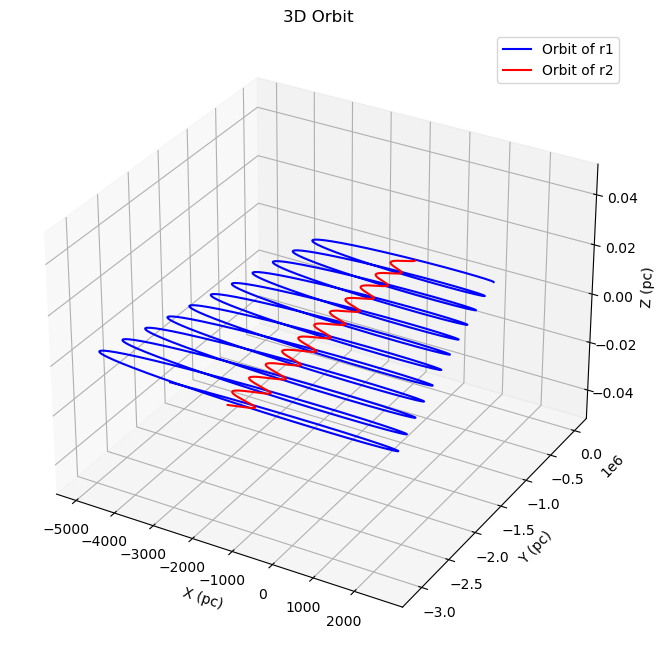

In [13]:
from mpl_toolkits.mplot3d import Axes3D  


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.plot(first_four_r1[:, 0], first_four_r1[:, 1], first_four_r1[:, 2], label="Orbit of r1", color="blue")


ax.plot(first_four_r2[:, 0], first_four_r2[:, 1], first_four_r2[:, 2], label="Orbit of r2", color="red")


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')
ax.set_title('3D Orbit')


ax.legend()


plt.show()